# Data

Read in the three files: clients.csv, loans.csv, payments.csv. These files are related by the following:
1. The clients file is the parent of the loans file. Each client can have multiple distinct loans. The client_id column links the two files
2. The loans file is the child of the clients file and the parent of the payments file. Each loan can have multiple distinct payments associated with it. The loan_id column links the two files.

In [133]:
# Import basic packages.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [134]:
# Read the data sets into data frames.
clients = pd.read_csv('clients.csv')
loans = pd.read_csv('loans.csv')
payments = pd.read_csv('payments.csv')

In [203]:
# Quick check of the structure of the data.
x = clients.info()
x = loans.info()
x = payments.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   client_id     25 non-null     int64         
 1   joined        25 non-null     datetime64[ns]
 2   income        25 non-null     int64         
 3   credit_score  25 non-null     int64         
 4   joined_year   25 non-null     int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 1.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443 entries, 0 to 442
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   client_id    443 non-null    int64  
 1   loan_type    443 non-null    object 
 2   loan_amount  443 non-null    int64  
 3   repaid       443 non-null    int64  
 4   loan_id      443 non-null    int64  
 5   loan_start   443 non-null    object 
 6   loan_end     443 non-null    object 
 7   rate

In [136]:
print(clients.shape)
print(loans.shape)
print(payments.shape)

(25, 4)
(443, 8)
(3456, 4)


With the above datasets, answer the following questions. Show the steps taken to produce your final answer.

# Section 1 Questions

1. Give the 5 client IDs with the highest mean payment amount
2. How many unique loans have been given out to clients who joined prior to 2001?
3. What is the mean number of payments missed by clients with a credit score of less than 700 and who have missed more than 50 payments?

In [137]:
# loan_ids with highest mean payment amount.
highest_loan_ids = payments[['loan_id', 'payment_amount']]. \
                   groupby('loan_id'). \
                   mean(). \
                   sort_values(ascending=False, by='payment_amount'). \
                   head(5)
# Client ids with top 5 mean payment amount.
pd.merge(highest_loan_ids, loans, on='loan_id')['client_id']

0    38537
1    49545
2    26695
3    35214
4    29841
Name: client_id, dtype: int64

In [138]:
# Convert the attribute 'joined' in the dataframe clients in datatime format.
clients['joined'] = pd.to_datetime(clients['joined'])
clients_prior_to_2001 = clients.loc[clients['joined'].dt.year <= 2001]['client_id']
pd.merge(clients_prior_to_2001, loans, on='client_id')

,client_id,loan_type,loan_amount,repaid,loan_id,loan_start,loan_end,rate
0,46180,home,3022,0,11204,2003-11-22,2005-05-18,8.39
1,46180,credit,9282,1,10664,2008-03-03,2010-05-16,3.16
2,46180,cash,14007,1,10416,2003-12-05,2005-05-14,3.95
3,46180,cash,5943,0,11317,2011-10-18,2013-11-03,6.86
4,46180,other,3834,0,10887,2014-05-03,2016-02-24,1.38
...,...,...,...,...,...,...,...,...
80,26945,other,12963,0,10330,2001-11-26,2004-06-11,2.46
81,26945,credit,1728,1,10248,2004-01-27,2005-06-21,5.27
82,26945,other,9329,0,10154,2001-12-17,2004-07-22,5.65
83,26945,home,4197,0,10333,2003-10-16,2005-07-10,4.50


# Section 2 Questions

In [139]:
# Clients with credit score < 700.
clients_poor_cs = clients.loc[clients['credit_score'] < 700]['client_id']
# Loan ids of these clients.
loan_ids_poor_cs = pd.merge(clients_poor_cs, loans, on='client_id')[['client_id', 'loan_id']]
# Payment details of these clients.
payments_poor_cs = pd.merge(loan_ids_poor_cs, payments, on='loan_id')
# Get count of missed payments by client.
missed_payments = payments_poor_cs.loc[payments_poor_cs['missed'] == 1].groupby('client_id').count()['missed']
# Get the mean number of missed payments where the missed count > 50. 
missed_payments[missed_payments > 50].mean()


69.25

Create the following visualizations:
    
1. Create a histogram of the payment amounts. Briefly describe the distribution.
2. Produce a line plot the cumulative sum of the number of clients by year.
3. Produce a scatter plot of the percentage of payments missed in december for each year in the dataset.

<AxesSubplot:>

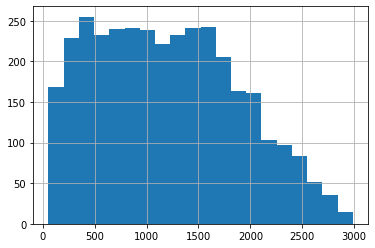

In [204]:
payments['payment_amount'].hist(bins=20)

Text(0.5, 1.0, 'Cumulative sum of clients by year')

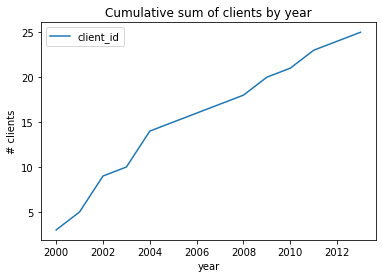

In [141]:
clients['joined_year'] = clients['joined'].dt.year
ax = clients[['client_id', 'joined_year']].groupby('joined_year').count().cumsum().reset_index().plot('joined_year', 'client_id')
ax.set_xlabel('year')
ax.set_ylabel('# clients')
ax.set_title('Cumulative sum of clients by year')


Text(0.5, 1.0, 'Percentage of payments missed in December')

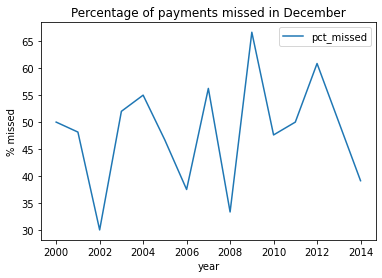

In [142]:
payments['payment_date'] = pd.to_datetime(payments['payment_date'])
payments['payment_year'] = payments['payment_date'].dt.year
payments['payment_month'] = payments['payment_date'].dt.month
dec_count = payments.loc[payments['payment_month'] == 12][['loan_id', 'payment_year']].groupby('payment_year').count().rename(columns={'loan_id': 'n_loans'}).reset_index()
#
dec_missed_count = payments.loc[((payments['payment_month'] == 12) & (payments['missed'] == 1))][['loan_id', 'payment_year']].groupby('payment_year').count().rename(columns={'loan_id': 'n_loans_missed'}).reset_index()

X = pd.merge(dec_count, dec_missed_count, on='payment_year')
X['pct_missed'] = round(X['n_loans_missed']/X['n_loans'] * 100, 2)
ax = X.plot('payment_year', 'pct_missed')
ax.set_xlabel('year')
ax.set_ylabel('% missed')
ax.set_title('Percentage of payments missed in December')

# Section 3 - Modelling

Create a model that will predict whether a person does or does not have diabetes. Use the diabetes.csv dataset. The target column in the dataset is "Outcome". Assume no features leak information about the target.

Your solution should include the below. You may use whichever python libraries you wish to complete the task:
1. Feature engineering
2. Model fitting and performance evaluation
3. A function that takes as arguments: a model, train data, test data, and returns the model's predictions on the test data
4. A function that takes a set of predictions and true values and that validates the predictions using appropriate metrics
5. Anything else you feel is necessary for modelling or improving the performance of your model


__This exercise is intended for you to show your proficiency in machine learning, understanding of the various techniques that can be employed to improve the performance of a model, and your ability to implement those techniques. Please, therefore, show your working at all times. You will be judged more for the above than for the performance of the final model your produce.__

In [143]:
# Read the data, conduct a preliminary examination
all_diab = pd.read_csv('test_diabetes.csv', sep=';')

In [144]:
all_diab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               731 non-null    float64
 1   Glucose                   730 non-null    float64
 2   BloodPressure             734 non-null    float64
 3   SkinThickness             734 non-null    float64
 4   Insulin                   717 non-null    object 
 5   BMI                       733 non-null    float64
 6   DiabetesPedigreeFunction  728 non-null    float64
 7   Age                       717 non-null    float64
 8   Outcome                   768 non-null    object 
dtypes: float64(7), object(2)
memory usage: 54.1+ KB


In [145]:
all_diab.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,NaN,148.0,72.0,35.0,0,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.0,0,26.6,0.351,31.0,0
2,8.0,183.0,64.0,0.0,0,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.0,94,28.1,0.167,21.0,0
4,0.0,NaN,40.0,35.0,168,43.1,2.288,NaN,1


In [146]:
# Why is Insulin not numeric?
all_diab['Insulin'].unique()

array(['0', '94', '168', 'Zero', '88', '543', '846', '175', '230', nan,
       '96', '235', '146', '115', '110', '245', '54', '192', '207', '70',
       '240', '82', '36', '23', '300', '342', '142', '128', '38', '90',
       '140', '270', '71', '125', '176', '48', '64', '228', '76', '220',
       '40', '152', '18', '135', '495', '37', '51', '100', '99', '145',
       '225', '49', '50', '92', '325', '63', '119', '204', '155', '485',
       '53', '114', '105', '285', '156', '78', '55', '130', '58', '160',
       '210', '318', '44', '190', '280', '271', '129', '120', '478', '56',
       '32', '370', '45', '194', '680', '402', '258', '375', '150', '67',
       '57', '116', '278', '122', '545', '75', '74', '182', '360', '215',
       '184', '42', '132', '148', '180', '205', '85', '231', '29', '68',
       '52', '255', '171', '73', '108', '83', '43', '167', '249', '293',
       '66', '465', '89', '158', '84', '72', '59', '81', '196', '415',
       '87', '275', '165', '579', '310', '61', '474

In [147]:
# We must replace 'Zero' in the column 'Insulin' with '0'
all_diab.loc[all_diab['Insulin'] =='Zero', 'Insulin'] = 0

In [148]:
all_diab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               731 non-null    float64
 1   Glucose                   730 non-null    float64
 2   BloodPressure             734 non-null    float64
 3   SkinThickness             734 non-null    float64
 4   Insulin                   717 non-null    object 
 5   BMI                       733 non-null    float64
 6   DiabetesPedigreeFunction  728 non-null    float64
 7   Age                       717 non-null    float64
 8   Outcome                   768 non-null    object 
dtypes: float64(7), object(2)
memory usage: 54.1+ KB


In [149]:
# Convert 'Insulin' to float
all_diab['Insulin'] = all_diab['Insulin'].apply(lambda s: float(s))

In [150]:
all_diab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               731 non-null    float64
 1   Glucose                   730 non-null    float64
 2   BloodPressure             734 non-null    float64
 3   SkinThickness             734 non-null    float64
 4   Insulin                   717 non-null    float64
 5   BMI                       733 non-null    float64
 6   DiabetesPedigreeFunction  728 non-null    float64
 7   Age                       717 non-null    float64
 8   Outcome                   768 non-null    object 
dtypes: float64(8), object(1)
memory usage: 54.1+ KB


In [151]:
# Why is 'Outcome' and object?
all_diab['Outcome'].unique()

array(['1', '0', 'N', 'Y'], dtype=object)

In [152]:
# Replace 'N' with '0' and 'Y' with '1'
all_diab.loc[all_diab['Outcome'] == 'N', 'Outcome'] = '0'
all_diab.loc[all_diab['Outcome'] == 'Y', 'Outcome'] = '1'
all_diab['Outcome'].unique()

array(['1', '0'], dtype=object)

In [153]:
# Convert '1' and '0' to respective integers
all_diab['Outcome'] = all_diab['Outcome'].apply(lambda s: int(s))

In [154]:
all_diab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               731 non-null    float64
 1   Glucose                   730 non-null    float64
 2   BloodPressure             734 non-null    float64
 3   SkinThickness             734 non-null    float64
 4   Insulin                   717 non-null    float64
 5   BMI                       733 non-null    float64
 6   DiabetesPedigreeFunction  728 non-null    float64
 7   Age                       717 non-null    float64
 8   Outcome                   768 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 54.1 KB


In [155]:
# By this stage, we have cleaned the data. All values are numeric. There are a few 'NaN's but they need a 
# separate consideration.
all_diab[all_diab.applymap(np.isnan).any(True)]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,NaN,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1
4,0.0,NaN,40.0,35.0,168.0,43.1,2.288,NaN,1
5,5.0,116.0,74.0,NaN,0.0,25.6,0.201,30.0,0
7,NaN,NaN,0.0,0.0,0.0,35.3,0.134,29.0,0
9,8.0,125.0,NaN,0.0,0.0,0.0,0.232,54.0,1
...,...,...,...,...,...,...,...,...,...
756,NaN,137.0,90.0,41.0,0.0,32.0,0.391,39.0,0
759,NaN,190.0,92.0,NaN,0.0,35.5,0.278,66.0,1
762,NaN,89.0,62.0,0.0,0.0,22.5,0.142,33.0,0
763,10.0,101.0,76.0,NaN,180.0,32.9,0.171,63.0,0


In [156]:
all_diab.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,731.000000,730.000000,734.000000,734.000000,717.000000,733.000000,728.000000,717.000000,768.000000
mean,3.824897,121.152055,69.008174,20.848774,79.994421,31.979536,0.472702,34.108787,0.348958
std,3.369400,31.774802,19.496036,15.876665,113.612888,7.918709,0.331714,16.119730,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,-1.000000,0.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,27.400000,0.245000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,36.000000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,32.000000,130.000000,36.500000,0.624500,41.000000,1.000000
max,17.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.420000,200.000000,1.000000


In [157]:
# Find the number of NaN's in each column
C = all_diab.describe().loc[['count']]
C = (all_diab.shape[0] - C)
C

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,37.0,38.0,34.0,34.0,51.0,35.0,40.0,51.0,0.0


In [158]:
# How do the medians look like?
all_diab.median()

Pregnancies                   3.0000
Glucose                     117.0000
BloodPressure                72.0000
SkinThickness                23.0000
Insulin                      36.0000
BMI                          32.0000
DiabetesPedigreeFunction      0.3725
Age                          29.0000
Outcome                       0.0000
dtype: float64

In [159]:
# Let us impute all the NaN's with respective medians.
all_diab = all_diab.fillna(all_diab.median())

In [160]:
# Does the data look good now?
all_diab.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.785156,120.946615,69.140625,20.944010,77.072917,31.980469,0.467483,33.769531,0.348958
std,3.291875,30.990784,19.068969,15.527097,110.316623,7.735926,0.323716,15.626516,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,-1.000000,0.000000
25%,1.000000,100.000000,64.000000,0.000000,0.000000,27.500000,0.251000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,36.000000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,139.000000,80.000000,32.000000,122.000000,36.225000,0.602000,40.000000,1.000000
max,17.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.420000,200.000000,1.000000


In [161]:
# Check the population of each class
all_diab.groupby('Outcome').count()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,500,500,500,500,500,500,500,500
1,268,268,268,268,268,268,268,268


In [162]:
# How skewed are the X's?
all_diab.describe().loc[['mean', '50%']]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
mean,3.785156,120.946615,69.140625,20.94401,77.072917,31.980469,0.467483,33.769531,0.348958
50%,3.000000,117.000000,72.000000,23.00000,36.000000,32.000000,0.372500,29.000000,0.000000


<AxesSubplot:>

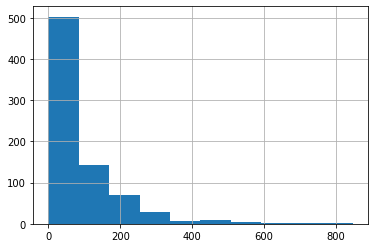

In [163]:
# There is a huge difference between mean and median of Insulin. The data seems to be skewed to the right.
all_diab['Insulin'].hist()

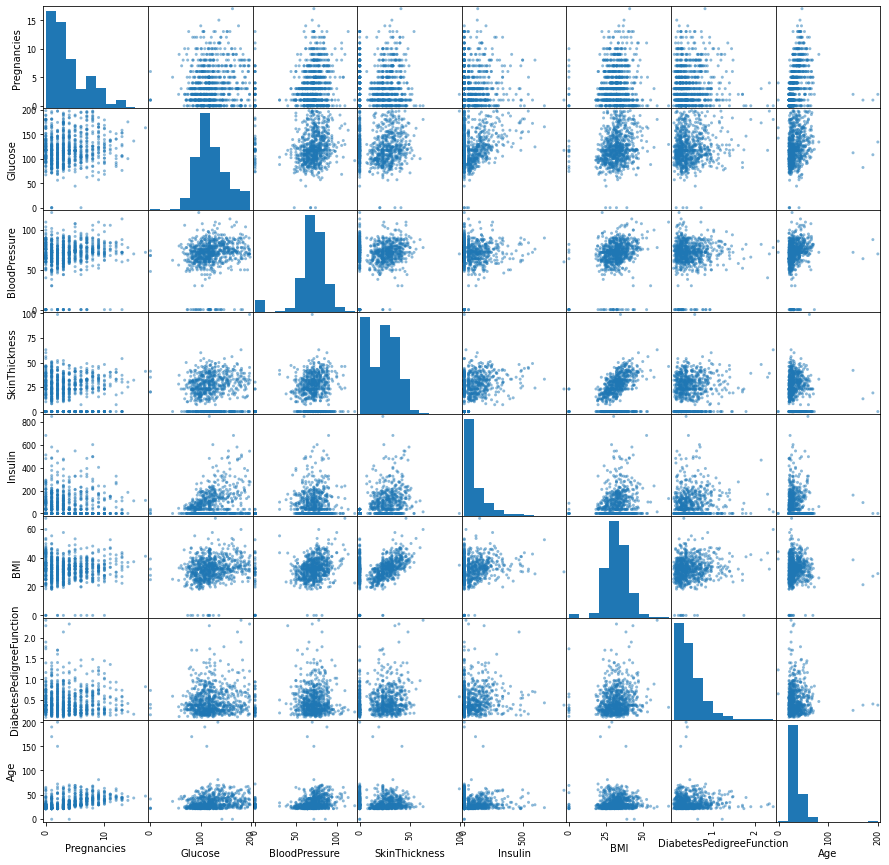

In [164]:
all_Xs = ['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']
sm = pd.plotting.scatter_matrix(all_diab[all_Xs], figsize=(15, 15))

In [165]:
# Only BMI and SkinThickness seem to be correlated. Quite naturally!!
# Next run t-test to check if the means of X's in groups 0 and 1 are similar.
from scipy.stats import stats

Y = 'Outcome'
for x in all_Xs:
  print(all_diab[[x, Y]].groupby(Y).mean().round(2).transpose())
  print(stats.f_oneway(all_diab.loc[all_diab[Y]==0][x], all_diab.loc[all_diab[Y]==1][x]))
  print('-'*80)

Outcome         0     1
Pregnancies  3.27  4.75
F_onewayResult(statistic=36.72476059147227, pvalue=2.1329943841169955e-09)
--------------------------------------------------------------------------------
Outcome       0       1
Glucose  110.48  140.48
F_onewayResult(statistic=207.6203557221851, pvalue=7.935358051128253e-42)
--------------------------------------------------------------------------------
Outcome            0      1
BloodPressure  68.34  70.63
F_onewayResult(statistic=2.5308490913930197, pvalue=0.11205271603329084)
--------------------------------------------------------------------------------
Outcome            0      1
SkinThickness  20.16  22.41
F_onewayResult(statistic=3.6845965993834096, pvalue=0.05528843662170775)
--------------------------------------------------------------------------------
Outcome      0      1
Insulin  66.26  97.25
F_onewayResult(statistic=14.004335855980598, pvalue=0.00019602410892913364)
-----------------------------------------------------

In [166]:
# SkinThickness and BloodPressure are not significantly different in diabetics and non-diabetics. We can drop these
# variables. We will now try a logistic regression model.
import random
from patsy import dmatrices
import statsmodels.api as sm

def get_split(N, p):
    """ Split data indexed 0 to (N-1) into training and test."""
    n_train = int(N * p)
    train_indices = set(random.sample(range(N), n_train))
    test_indices = set(range(N)) - train_indices
    
    assert len(train_indices.intersection(test_indices)) == 0
    assert len(train_indices) + len(test_indices) == N
    
    # Return both as lists
    return [[i for i in train_indices], [i for i in test_indices]]

train_indices, test_indices = get_split(all_diab.shape[0], 0.70)

trn_data = all_diab.iloc[train_indices, :]
tst_data = all_diab.iloc[test_indices, :]

assert trn_data.shape[0] + tst_data.shape[0] == all_diab.shape[0]

In [175]:
def print_cm_results(cm):
    """Print diagnostics from the confusion matrix"""
    recall = cm[0, 0]/(cm[0, 0] + cm[1, 0])
    precision = cm[0, 0]/(cm[0, 0] + cm[0, 1])
    specificity = cm[1, 1]/(cm[1, 0] + cm[1, 1])
    f1_score = 2*recall*precision/(recall + precision)
    accuracy = np.trace(cm)/np.sum(cm)
    
    print(f'% +ves correctly predicted = {round(recall * 100, 2)}')
    print(f'% +ves detected out of all = {round(precision * 100, 2)}')
    print(f'% -ves detected out of all = {round(specificity * 100, 2)}')
    print(f'f1 score = {round(f1_score, 2)}')
    print(f'accuracy = {round(accuracy * 100, 2)}')
    
print_cm_results(cm)

% +ves correctly predicted = 77.72
% +ves detected out of all = 88.2
% -ves detected out of all = 50.28
f1 score = 0.83
accuracy = 75.42


In [176]:
# Let us try using all X's.
def get_model_matrices_v0(D):
    return dmatrices('Outcome ~ Pregnancies + Glucose + BloodPressure + SkinThickness + Insulin + BMI + DiabetesPedigreeFunction + Age', \
                     data = D, return_type='dataframe')

# Training model matrices
yn, Xn = get_model_matrices_v0(trn_data)
yt, Xt = get_model_matrices_v0(tst_data)

# Version 0 of the model.
model_v0 = sm.Logit(yn, Xn)
results_v0 = model_v0.fit()
print(results_v0.summary())

Optimization terminated successfully.
         Current function value: 0.482917
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  537
Model:                          Logit   Df Residuals:                      528
Method:                           MLE   Df Model:                            8
Date:                Fri, 11 Sep 2020   Pseudo R-squ.:                  0.2443
Time:                        13:18:24   Log-Likelihood:                -259.33
converged:                       True   LL-Null:                       -343.18
Covariance Type:            nonrobust   LLR p-value:                 3.907e-32
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -7.9148      0.842     -9.401      0.000      -9.565

In [177]:
# Training data performance
cm_v0 = results_v0.pred_table()
print(cm_v0)
print_cm_results(cm_v0)

[[314.  42.]
 [ 90.  91.]]
% +ves correctly predicted = 77.72
% +ves detected out of all = 88.2
% -ves detected out of all = 50.28
f1 score = 0.83
accuracy = 75.42


In [178]:
def get_model_matrices_v1(D):
    return dmatrices('Outcome ~ Pregnancies + Glucose + Insulin + BMI + DiabetesPedigreeFunction + Age', \
                    data = D, return_type='dataframe')

# Training model matrices
yn, Xn = get_model_matrices_v1(trn_data)
yt, Xt = get_model_matrices_v1(tst_data)

In [179]:
# Version 1 of the model.
model_v1 = sm.Logit(yn, Xn)
results_v1 = model_v1.fit()
print(results_v1.summary())

Optimization terminated successfully.
         Current function value: 0.489678
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  537
Model:                          Logit   Df Residuals:                      530
Method:                           MLE   Df Model:                            6
Date:                Fri, 11 Sep 2020   Pseudo R-squ.:                  0.2338
Time:                        13:18:29   Log-Likelihood:                -262.96
converged:                       True   LL-Null:                       -343.18
Covariance Type:            nonrobust   LLR p-value:                 4.775e-32
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -8.3291      0.820    -10.158      0.000      -9.936

In [180]:
# Training data performance
cm_v1 = results_v1.pred_table()
print(cm_v1)
print_cm_results(cm_v1)

[[316.  40.]
 [ 90.  91.]]
% +ves correctly predicted = 77.83
% +ves detected out of all = 88.76
% -ves detected out of all = 50.28
f1 score = 0.83
accuracy = 75.79


In [181]:
# Quite surprisingly, only Pregnancies and Glucose remain!!
def get_model_matrices_v2(D):
    return dmatrices('Outcome ~ Pregnancies + Glucose + BMI + DiabetesPedigreeFunction', \
                     data = D, return_type='dataframe')

# Training model matrices
yn, Xn = get_model_matrices_v2(trn_data)
yt, Xt = get_model_matrices_v2(tst_data)

# Version 2 of the model.
model_v2 = sm.Logit(yn, Xn)
results_v2 = model_v2.fit()
print(results_v2.summary())

Optimization terminated successfully.
         Current function value: 0.493353
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  537
Model:                          Logit   Df Residuals:                      532
Method:                           MLE   Df Model:                            4
Date:                Fri, 11 Sep 2020   Pseudo R-squ.:                  0.2280
Time:                        13:18:30   Log-Likelihood:                -264.93
converged:                       True   LL-Null:                       -343.18
Covariance Type:            nonrobust   LLR p-value:                 8.255e-33
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -7.9387      0.779    -10.197      0.000      -9.465

In [182]:
# Training data performance
cm_v2 = results_v2.pred_table()
print(cm_v2)
print_cm_results(cm_v2)

[[316.  40.]
 [ 93.  88.]]
% +ves correctly predicted = 77.26
% +ves detected out of all = 88.76
% -ves detected out of all = 48.62
f1 score = 0.83
accuracy = 75.23


In [185]:
# Print all confusion matrices
cms = [cm_v0, cm_v1, cm_v2]
for i, cm in enumerate(cms):
    print(f'Confusion matrix for version {i}:')
    print_cm_results(cm)
    print('-' * 80)

Confusion matrix for version 0:
% +ves correctly predicted = 77.72
% +ves detected out of all = 88.2
% -ves detected out of all = 50.28
f1 score = 0.83
accuracy = 75.42
--------------------------------------------------------------------------------
Confusion matrix for version 1:
% +ves correctly predicted = 77.83
% +ves detected out of all = 88.76
% -ves detected out of all = 50.28
f1 score = 0.83
accuracy = 75.79
--------------------------------------------------------------------------------
Confusion matrix for version 2:
% +ves correctly predicted = 77.26
% +ves detected out of all = 88.76
% -ves detected out of all = 48.62
f1 score = 0.83
accuracy = 75.23
--------------------------------------------------------------------------------


In [202]:
# Going by the scores on training data, version 1 looks to be the best.
# We will check how it does on the test data.
yt, Xt = get_model_matrices_v1(tst_data)
yt_pred = results_v1.predict(Xt)

def prob_to_outcome(y, threshold = 0.5):
    if y < threshold:
        return 0
    else:
        return 1
    
yt['predicted'] = [prob_to_outcome(y) for y in yt_pred]
yt.columns = ['actual', 'predicted']
yt['actual'] = yt['actual'].apply(lambda f: int(f))
tcm_v1 = pd.crosstab(yt['actual'], yt['predicted']).to_numpy()
print(f'Test Confusion matrix for version 1:')
print_cm_results(tcm_v1)

Test Confusion matrix for version 1:
% +ves correctly predicted = 78.31
% +ves detected out of all = 90.28
% -ves detected out of all = 58.62
f1 score = 0.84
accuracy = 78.35
